### Data

In [1]:
df = pd.read_pickle('data/df.pkl')
print(df.shape)
df[:2]

(84754, 21)


,AuthorID,Author,Date,Content,Attachments,Reactions,Date_day,Date_month,Date_quarter,id1,Channel1,Channel2,Channel2_img,flg_bot,Content2,cnt_messages,cnt_reactions,cnt_attachments,cnt_words,cnt_chars,flg_join
30165,451343325018980353,sheridan_oceanprotocol,2019-08-20 19:55:00,Joined the server.,NaN,NaN,2019-08-20,2019-08,2019Q3,30165,GENERAL,general-chat,💭,0,joined the server,0,0,0,3,18,1
30166,236850565382930432,kremalicious,2019-08-20 22:22:00,Joined the server.,NaN,NaN,2019-08-20,2019-08,2019Q3,30166,GENERAL,general-chat,💭,0,joined the server,0,0,0,3,18,1


In [2]:
# text preprocessing
# df['Content'] = df['Content'].fillna('').map(lambda x: re.sub('http.*', 'http', x))
# df['Content'] = df['Content'].fillna('').map(lambda x: re.sub('@[A-Za-z0-9_]+','user', x))

# filtering
f0 = df['cnt_words'] > 1
f1 = df['flg_join'] == 0
f2 = df['flg_bot'] == 0
f3 = df['Content2'].str.contains('issue|error|bug|problem|stuck')

filt = f0&f1&f2&f3

df1 = df[filt].sort_values(['Channel2','Date'])
print(df1.shape)

(1071, 21)


56473


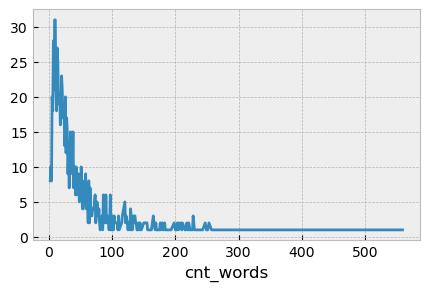

In [3]:
print(df1.cnt_words.sum())
_ = df1['cnt_words'].value_counts().sort_index().plot(figsize = (5,3))

In [4]:
text = list(df1['Content'])
len(text)

1071

### Get GPT-3.5 openai embeddings

In [5]:
import os

import hdbscan
import requests

import numpy as np
import pandas as pd
import plotly.express as px

from langchain import LLMChain
from langchain.chat_models import ChatOpenAI
# from langchain.embeddings.openai import OpenAIEmbeddings
from langchain_openai import OpenAIEmbeddings
from langchain.prompts.chat import (
    ChatPromptTemplate,
    SystemMessagePromptTemplate,
    HumanMessagePromptTemplate,
)
from sklearn.manifold import TSNE
from dotenv import load_dotenv

load_dotenv()

True

In [6]:
OPENAI_SECRET_KEY = os.getenv('OPENAI_SECRET_KEY')
model_emb = OpenAIEmbeddings(api_key = OPENAI_SECRET_KEY, chunk_size=1000)

In [7]:
list_emb = model_emb.embed_documents(text)

### Create clusters

In [8]:
model_cl = hdbscan.HDBSCAN(gen_min_span_tree=False, metric='euclidean', min_samples=1, min_cluster_size=2, alpha = 1.1)
model_cl.fit(list_emb)

HDBSCAN(alpha=1.1, min_cluster_size=2, min_samples=1)

In [9]:
df1["cluster"] =  model_cl.labels_

### View results

In [11]:
df1['cluster_len'] = df1.groupby(['Channel2','cluster'])['AuthorID'].transform(len)
feats = ['Date','Author','Channel2','Content','cluster','cluster_len']
df1[feats][:5]

,Date,Author,Channel2,Content,cluster,cluster_len
15872,2023-03-29 02:11:00,swish24_08,ai-fun,"He is kinda right, the problem is i'm constant...",-1,5
16088,2023-03-29 06:55:00,lukas85#6738,ai-fun,@OceanDiffusion puzzle humans are stuck in,-1,5
16828,2023-04-08 04:24:00,nickscavuzzo33,ai-fun,@OceanDiffusion blockchain solving problems,-1,5
16977,2023-04-16 05:52:00,lukas85#6738,ai-fun,"it gets stuck sometimes, maybe it has internal...",-1,5
16986,2023-04-16 05:55:00,lukas85#6738,ai-fun,@OceanDiffusion are you having issue generatin...,-1,5


In [12]:
f1 = df1['cluster_len'] > 2
f2 = df1['cluster'] != -1
df1[f1].shape, df1[f1&f2].cluster.nunique()

((879, 23), 27)

In [14]:
# ['general-chat', 'ambassadors', 'treasure-hunter', 'ask-the-ai', 'predictoor', 'data-science-hub'][0]
f0 = df1['Channel2'] == 'general-chat'
f1 = df1['cluster'] != -1
f2 = df1['cluster_len'] > 2
x = df1[f1&f2].groupby(['cluster']).Content.agg(lambda x: '\n'.join(x))

In [16]:
# pd.set_option('display.max_colwidth',1500)
# for k,v in dict(x).items():
#     print('---------')
#     print(k)
#     print(v)

In [ ]:
# User-related: 
# 	Predictoor:
# 		I am trying to deploy my bot on a cloud run service.

# System-related:
# 	Predictoor:
# 		There was a problem on our end submitting the trueVal for the past few slots...
# 		Is the difficulty in claiming rewards related to subgraph syncing or other issues?
# 	Challenges:
# 		There was an issue that came up this weekend relating to problems downloading the data sets provided in our newest challenge
# 	General:
# 		please open a thread in #🐛┃tech-issues
	
# External factors:
# 	Questbook (OLD):
# 		You're right there seems to be a bug on Questbook..
# 	Datalatte:
# 		datalatte I’ve done the survey but it’s having issues submitting..showing there is something wrong
# 	General:
# 		There are no liquity pools on the BSC chain for OCEAN. That is the problem. Binance closed down in my country(Canada)
